for one light curve, 3 obs in two fitlters; > 5sigma;

all combination of time gaps, observations;



one light curve, multiple combinations

f1 f2 f3

total number of events



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
from lsst.sims.maf.utils import m52snr
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.plots as plots

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from lsst.utils import getPackageDir
#from mafContrib import KN_lc, KNePopMetric, generateKNPopSlicer
import healpy as hp
import os

In [51]:
from lsst.sims.photUtils import Sed, BandpassDict


class Dust_values(object):
    """Calculate extinction values
    Parameters
    ----------
    R_v : float (3.1)
        Extinction law parameter (3.1).
    bandpassDict : dict (None)
        A dict with keys of filtername and values of rubin_sim.photUtils.Bandpass objects. Default
        of None will load the standard ugrizy bandpasses.
    ref_ev : float (1.)
        The reference E(B-V) value to use. Things in MAF assume 1.
    """
    def __init__(self, R_v=3.1, bandpassDict=None, ref_ebv=1.):
        # Calculate dust extinction values
        self.Ax1 = {}
        if bandpassDict is None:
            bandpassDict = BandpassDict.loadTotalBandpassesFromFiles(['u', 'g', 'r', 'i', 'z', 'y'])

        for filtername in bandpassDict:
            wavelen_min = bandpassDict[filtername].wavelen.min()
            wavelen_max = bandpassDict[filtername].wavelen.max()
            testsed = Sed()
            testsed.setFlatSED(wavelen_min=wavelen_min, wavelen_max=wavelen_max, wavelen_step=1.0)
            self.ref_ebv = ref_ebv
            # Calculate non-dust-extincted magnitude
            flatmag = testsed.calcMag(bandpassDict[filtername])
            # Add dust
            a, b = testsed.setupCCM_ab()
            testsed.addDust(a, b, ebv=self.ref_ebv, R_v=R_v)
            # Calculate difference due to dust when EBV=1.0 (m_dust = m_nodust - Ax, Ax > 0)
            self.Ax1[filtername] = testsed.calcMag(bandpassDict[filtername]) - flatmag



In [3]:
import glob
import os
import numpy as np
import lsst.sims.maf.metrics as metrics
#from lsst.sims.utils import uniformSphere
import lsst.sims.maf.slicers as slicers
#from lsst.sims.photUtils import Dust_values


__all__ = ['KN_lc', 'KNePopMetric', 'generateKNPopSlicer']


def uniformSphere(npoints, seed=42):
    """
    Just make RA, dec points on a sphere
    """
    np.random.seed(seed)
    u = np.random.uniform(size=npoints)
    v = np.random.uniform(size=npoints)

    ra = 2.*np.pi * u
    dec = np.arccos(2.*v - 1.)
    # astro convention of -90 to 90
    dec -= np.pi/2.
    return np.degrees(ra), np.degrees(dec)


class KN_lc(object):
    """
    Read in some KNe lightcurves
    Parameters
    ----------
    file_list : list of str (None)
        List of file paths to load. If None, loads up all the files from data/bns/
    """
    def __init__(self, file_list=None):
        if file_list is None:
            sims_maf_contrib_dir = os.getenv("SIMS_MAF_CONTRIB_DIR")
            # Get files, model grid developed by M. Bulla
            file_list = glob.glob(os.path.join(sims_maf_contrib_dir, 'data/bns/*.dat'))

        filts = ["u", "g", "r", "i", "z", "y"]
        magidxs = [1, 2, 3, 4, 5, 6]

        # Let's organize the data in to a list of dicts for easy lookup
        self.data = []
        for filename in file_list:
            mag_ds = np.loadtxt(filename)
            t = mag_ds[:, 0]
            new_dict = {}
            for ii, (filt, magidx) in enumerate(zip(filts, magidxs)):
                new_dict[filt] = {'ph': t, 'mag': mag_ds[:, magidx]}
            self.data.append(new_dict)

    def interp(self, t, filtername, lc_indx=0):
        """
        t : array of floats
            The times to interpolate the light curve to.
        filtername : str
            The filter. one of ugrizy
        lc_index : int (0)
            Which file to use.
        """

        result = np.interp(t, self.data[lc_indx][filtername]['ph'],
                           self.data[lc_indx][filtername]['mag'],
                           left=99, right=99)
        return result

In [4]:
def generateKNPopSlicer(t_start=1, t_end=3652, n_events=10000, seed=42,
                        n_files=100, d_min=10, d_max=300):
    """ Generate a population of KNe events, and put the info about them
    into a UserPointSlicer object
    Parameters
    ----------
    t_start : float (1)
        The night to start kilonova events on (days)
    t_end : float (3652)
        The final night of kilonova events
    n_events : int (10000)
        The number of kilonova events to generate
    seed : float
        The seed passed to np.random
    n_files : int (7)
        The number of different kilonova lightcurves to use
    d_min : float or int (10)
        Minimum luminosity distance (Mpc)
    d_max : float or int (300)
        Maximum luminosity distance (Mpc)
    """

    def rndm(a, b, g, size=1):
        """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
        r = np.random.random(size=size)
        ag, bg = a**g, b**g
        return (ag + (bg - ag)*r)**(1./g)

    ra, dec = uniformSphere(n_events, seed=seed)
    peak_times = np.random.uniform(low=t_start, high=t_end, size=n_events)
    file_indx = np.floor(np.random.uniform(low=0, high=n_files,
                                           size=n_events)).astype(int)

    # Define the distance
    distance = rndm(d_min, d_max, 4, size=n_events)

    # Set up the slicer to evaluate the catalog we just made
    slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    # Add any additional information about each object to the slicer
    slicer.slicePoints['peak_time'] = peak_times
    slicer.slicePoints['file_indx'] = file_indx
    slicer.slicePoints['distance'] = distance
    
    return slicer

In [5]:
class KNePopMetric(metrics.BaseMetric):
    def __init__(self, metricName='KNePopMetric', mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', nightCol='night',
                 ptsNeeded=2, file_list=None, mjd0=59853.5, outputLc=False,
                 **kwargs):
        maps = ['DustMap']
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.nightCol = nightCol
        self.ptsNeeded = ptsNeeded # detection points threshold
        # Boolean variable, if True the light curve will be exported
        self.outputLc = outputLc
        
        # read in file as light curve object;
        self.lightcurves = KN_lc(file_list=file_list)
        self.mjd0 = mjd0

        dust_properties = Dust_values()
        self.Ax1 = dust_properties.Ax1

        cols = [self.mjdCol, self.m5Col, self.filterCol, self.nightCol]
        super(KNePopMetric, self).__init__(col=cols, units='Detected, 0 or 1',
                                           metricName=metricName, maps=maps,
                                           **kwargs)

    def _multi_detect(self, around_peak):
        """
        Simple detection criteria: detect at least a certain number of times
        """
        result = 1
        # Detected data points
        if np.size(around_peak) < self.ptsNeeded:
            return 0

        return result
    
    def _presto_color_detect(self, around_peak, filters):
        """
        detection criteria of presto cadence: at least three detections at two filters;
        """
        result = 1
        
        if np.size(around_peak)<3:
            result = 0
        
        flts, flts_count = np.unique(filters, return_counts=True,)
        if np.size(flts) < 2:
            result = 0
        elif np.max(flts_count) < 2:
            # if no filters have visits larger than 2, set detection false
            result = 0

        return result

    def _ztfrest_simple(self, around_peak, mags, t, filters, min_dt=0.125,
                        min_fade=0.3, max_rise=-1., selectRed=False):
        """
        Selection criteria based on rise or decay rate; simplified version of
        the methods employed by the ZTFReST project
        (Andreoni & Coughlin et al., 2021)
        Parameters
        ----------
        around_peak : array
            indexes corresponding to 5sigma detections
        mags : array
            magnitudes obtained interpolating models on the dataSlice
        t : array
            relative times
        filters : array
            filters in which detections happened
        min_dt : float
            minimum time gap between first and last detection in a given band
        min_fade : float
            fade rate threshold (positive, mag/day)
        max_rise : float
            rise rate threshold (negative, mag/day)
        selectRed : bool
            if True, only red 'izy' filters will be considered
        Examples
        ----------
        A transient:
            rising by 0.74 mag/day will pass a threshold max_rise=-0.5
            rising by 0.74 mag/day will not pass a threshold max_rise=-1.0
            fading by 0.6 mag/day will pass a threshold min_fade=0.3
            fading by 0.2 mag/day will not pass a threshold min_fade=0.3
        """
        result = 1

        # Quick check on the number of detected points
        if np.size(around_peak) < self.ptsNeeded:
            return 0
        # Quick check on the time gap between first and last detection
        elif np.max(t[around_peak]) - np.min(t[around_peak]) < min_dt:
            return 0
        else:
            evol_rate = []
            fil = []
            # Check time gaps and rise or fade rate for each band
            for f in set(filters):
                if selectRed is True and not (f in 'izy'):
                    continue
                times_f = t[around_peak][np.where(filters == f)[0]]
                mags_f = mags[around_peak][np.where(filters == f)[0]]
                dt_f = np.max(times_f) - np.min(times_f)
                # Calculate the evolution rate, if the time gap condition is met
                if dt_f > min_dt:
                    evol_rate_f = (np.max(mags_f) - np.min(mags_f)) / (times_f[np.where(mags_f == np.max(mags_f))[0]][0] - times_f[np.where(mags_f == np.min(mags_f))[0]][0])
                    evol_rate.append(evol_rate_f)
                else:
                    evol_rate.append(0)
                fil.append(f)
            if len(evol_rate) == 0:
                return 0
            # Check if the conditions on the evolution rate are met
            if np.max(evol_rate) < min_fade and np.min(evol_rate) > max_rise:
                return 0

        return result

    def _multi_color_detect(self, filters):
        """
        Color-based simple detection criteria: detect at least twice,
        with at least two filters
        """
        result = 1
        # detected in at least two filters
        if np.size(np.unique(filters)) < 2:
            return 0

        return result

    def _red_color_detect(self, filters, min_det=4):
        """
        Detected at least min_det times in either izy colors
        Parameters
        ----------
        filters : array
            filters in which detections happened
        min_det : float or int
            minimum number of detections required in izy bands
        """
        result = 1
        # Number of detected points in izy bands
        n_red_det = np.size(np.where(filters == 'i')[0]) + np.size(np.where(filters == 'z')[0]) + np.size(np.where(filters == 'y')[0])
        # Condition
        if n_red_det < min_det:
            return 0

        return result

    def _blue_color_detect(self, filters, min_det=4):
        """
        Detected at least min_det times in either ugr colors
        Parameters
        ----------
        filters : array
            filters in which detections happened
        min_det : float or int
            minimum number of detections required in ugr bands
        """
        result = 1
        # Number of detected points in ugr bands
        n_blue_det = np.size(np.where(filters == 'u')[0]) + np.size(np.where(filters == 'g')[0]) + np.size(np.where(filters == 'r')[0])
        # Condition
        if n_blue_det < min_det:
            return 0

        return result

    def run(self, dataSlice, slicePoint=None):
        dataSlice.sort(order=self.mjdCol)
        result = {}
        t = dataSlice[self.mjdCol] - self.mjd0 - slicePoint['peak_time']
        mags = np.zeros(t.size, dtype=float)
        
        for filtername in np.unique(dataSlice[self.filterCol]):
            infilt = np.where(dataSlice[self.filterCol] == filtername)
            mags[infilt] = self.lightcurves.interp(t[infilt], filtername,
                                                   lc_indx=slicePoint['file_indx'])
            # Apply dust extinction on the light curve
            A_x = self.Ax1[filtername] * slicePoint['ebv']
            mags[infilt] += A_x

            distmod = 5*np.log10(slicePoint['distance']*1e6) - 5.0
            mags[infilt] += distmod

        # Find the detected points
        around_peak = np.where((t > 0) & (t < 30) & (mags < dataSlice[self.m5Col]))[0]        
        # Filters in which the detections happened
        filters = dataSlice[self.filterCol][around_peak]
        
        #result['multi_detect'] = self._multi_detect(around_peak)
        #result['ztfrest_simple'] = self._ztfrest_simple(around_peak, mags, t,
        #                                                filters,
        #                                                selectRed=False)
        #result['ztfrest_simple_red'] = self._ztfrest_simple(around_peak, mags,
        #                                                    t, filters,
        #                                                    selectRed=True)
        #result['multi_color_detect'] = self._multi_color_detect(filters)
        #result['red_color_detect'] = self._red_color_detect(filters)
        #result['blue_color_detect'] = self._blue_color_detect(filters)
        
        # presto color 
        result['presto_color_detect'] = self._presto_color_detect(around_peak, filters)

        # Export the light curve
        if self.outputLc is True:
            # mags[np.where(mags > 50)[0]] = 99.
            #result['lc'] = [dataSlice[self.mjdCol], mags,
            #                dataSlice[self.m5Col], dataSlice[self.filterCol]]
            
            idx = np.where(mags < 50)[0]
            
            result['lc'] = {'t': dataSlice[self.mjdCol][idx], 
                            'mag': mags[idx],
                            'maglim': dataSlice[self.m5Col][idx], 
                            'filter': dataSlice[self.filterCol][idx] }
            
            result['slicePoint'] = slicePoint
            
            # mag: interpolated mag at filter
            # maglim: observtion fiveSigmaDepth

        return result

    #def reduce_multi_detect(self, metric):
    #    return metric['multi_detect']

    #def reduce_ztfrest_simple(self, metric):
    #    return metric['ztfrest_simple']

    #def reduce_ztfrest_simple_red(self, metric):
    #    return metric['ztfrest_simple_red']

    #def reduce_multi_color_detect(self, metric):
    #    return metric['multi_color_detect']

    #def reduce_red_color_detect(self, metric):
    #    return metric['red_color_detect']

    #def reduce_blue_color_detect(self, metric):
    #    return metric['blue_color_detect']
    
    def reduce_presto_color_detect(self, metric):
        return metric['presto_color_detect']

In [6]:
def get_lc(t_obs, file_list, slicePoint, mjd0=59853.5):
    """return a light curve in all filters
    slicePoint: dict, peak_time, file_indx, ebv, distance
    """
            
    # read in file as light curve object;
    lightcurves = KN_lc(file_list=file_list)
    #self.mjd0 = mjd0

    dust_properties = Dust_values()
    Ax1 = dust_properties.Ax1
    
    filts = ['u', 'g', 'r', 'i', 'z', 'y']
    
    t_ph = t_obs - mjd0 - slicePoint['peak_time']
    lc_dic = {'t_obs':t_obs, 't_ph':t_ph,}

    for filtername in filts:
        #infilt = np.where(dataSlice[self.filterCol] == filtername)
        mags = lightcurves.interp(t_ph, filtername,
                                               lc_indx=slicePoint['file_indx'])
        # Apply dust extinction on the light curve
        A_x = Ax1[filtername] * slicePoint['ebv']
        mags += A_x

        distmod = 5*np.log10(slicePoint['distance']*1e6) - 5.0
        mags += distmod
        
        lc_dic[filtername] = mags
        
    
    return lc_dic


# run knemetric

In [7]:
# load opsim database
dbpath_v15 = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

dbpath_v17 = "/home/idies/workspace/lsst_cadence/FBS_1.7/"

dbpath_v171 = "/home/idies/workspace/lsst_cadence/FBS_1.7.1/"


# output directory
#dataRawDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir/tGaps/'

outDir = '/home/idies/workspace/Temporary/lianmign/scratch/Output'
resultsDb = db.ResultsDb(outDir=outDir)




In [8]:
# Generate the slicer which puts 10,000 events at random spots on the sphere
slicer = generateKNPopSlicer(seed=42, n_events=100, n_files=308)


In [9]:
# directory to maf_contrib
sims_maf_contrib_dir = "/home/idies/workspace/Storage/lianmign/persistent/sims_maf_contrib"

# Get files, model grid developed by M. Bulla
file_list = glob.glob(os.path.join(sims_maf_contrib_dir, 'data/bns/*.dat'))


In [10]:

runName = 'baseline_v1.5_10yrs' 
opsdb = db.OpsimDatabase(dbpath_v15 + runName+'.db')

#outDir = 'temp'
#resultsDb = db.ResultsDb(outDir=outDir)

metric = KNePopMetric(file_list=file_list, outputLc=True)
sql = ''
# Don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0}
plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics=[metrics.MeanMetric(maskVal=0)]
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName,
                                    plotDict=plotDict, plotFuncs=plotFuncs,
                                    summaryMetrics=summaryMetrics)


In [11]:
bd = metricBundles.makeBundlesDictFromList([bundle])
bgroup = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
#bgroup.plotAll(closefigs=False)


Querying database SummaryAllProps with no constraint for columns ['night', 'fiveSigmaDepth', 'fieldRA', 'fieldDec', 'observationStartMJD', 'filter'].
Found 2224095 visits
Running:  ['baseline_v1_5_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [12]:
outResults = bgroup.bundleDict['baseline_v1_5_10yrs_KNePopMetric_USER'].metricValues.data

In [27]:
outResults[44]

{'presto_color_detect': 1,
 'lc': {'t': array([59912.24533391, 59912.26114295, 59912.26799436, 59912.26840727,
         59912.28376109, 59912.28417459, 59925.22771889, 59925.2435047 ,
         59926.14684801, 59926.1626058 , 59928.1618407 , 59928.17759272]),
  'mag': array([23.38326054, 22.45573206, 22.45596946, 22.45598377, 22.06141044,
         22.0615005 , 27.9275573 , 26.66244659, 33.61257666, 30.3042942 ,
         28.83919908, 27.39766673]),
  'maglim': array([24.03049603, 23.70503371, 23.68179543, 23.61675769, 23.14005971,
         22.97252525, 22.60933911, 22.18404706, 23.72003061, 23.19428348,
         23.30374798, 22.66015113]),
  'filter': array(['g', 'r', 'r', 'r', 'i', 'i', 'i', 'z', 'g', 'r', 'i', 'z'],
        dtype='<U256')},
 'slicePoint': {'sid': 44,
  'ra': 1.62596257818143,
  'dec': 0.44484615297881813,
  'peak_time': 57.43210694689498,
  'file_indx': 122,
  'distance': 284.85060848951343,
  'ebv': 0.548012912273407}}

In [13]:
for i, res in enumerate(outResults):
    
    if res!=None:
        if res['presto_color_detect'] ==1:
            print(i)
    else: print('None', i)
    

None 0
None 2
None 8
None 9
None 10
None 11
None 17
None 23
None 24
None 28
None 30
None 31
None 32
None 33
None 38
None 41
None 43
44
None 45
None 48
None 51
None 52
None 55
None 58
None 64
None 67
None 68
69
None 71
None 75
None 79
None 80
None 81
None 89
None 90
None 94
None 95
97


In [33]:
pd.DataFrame(outResults[44]['lc'])

,t,mag,maglim,filter
0,59912.245334,23.383261,24.030496,g
1,59912.261143,22.455732,23.705034,r
2,59912.267994,22.455969,23.681795,r
3,59912.268407,22.455984,23.616758,r
4,59912.283761,22.061410,23.140060,i
5,59912.284175,22.061500,22.972525,i
6,59925.227719,27.927557,22.609339,i
7,59925.243505,26.662447,22.184047,z
8,59926.146848,33.612577,23.720031,g
9,59926.162606,30.304294,23.194283,r


In [35]:
df = pd.DataFrame(outResults[44]['lc'])
df

,t,mag,maglim,filter
0,59912.245334,23.383261,24.030496,g
1,59912.261143,22.455732,23.705034,r
2,59912.267994,22.455969,23.681795,r
3,59912.268407,22.455984,23.616758,r
4,59912.283761,22.061410,23.140060,i
5,59912.284175,22.061500,22.972525,i
6,59925.227719,27.927557,22.609339,i
7,59925.243505,26.662447,22.184047,z
8,59926.146848,33.612577,23.720031,g
9,59926.162606,30.304294,23.194283,r


In [41]:
df1 = df[df.mag<df.maglim]
df1

,t,mag,maglim,filter
0,59912.245334,23.383261,24.030496,g
1,59912.261143,22.455732,23.705034,r
2,59912.267994,22.455969,23.681795,r
3,59912.268407,22.455984,23.616758,r
4,59912.283761,22.061410,23.140060,i
5,59912.284175,22.061500,22.972525,i


In [56]:
dfCount = df1.groupby('filter').count()
dfCount

,t,mag,maglim
filter,,,
g,1,1,1
i,2,2,2
r,3,3,3


In [59]:
df1['t']

0    59912.245334
1    59912.261143
2    59912.267994
3    59912.268407
4    59912.283761
5    59912.284175
Name: t, dtype: float64

In [61]:
pd.unique(df1['filter'])

array(['g', 'r', 'i'], dtype=object)

In [29]:
outResults[14].keys()

dict_keys(['presto_color_detect', 'lc', 'slicePoint'])

In [24]:
outResults[14]['slicePoint']

{'sid': 14,
 'ra': 1.1424399624340646,
 'dec': -0.270078936979099,
 'peak_time': 2601.1663371398536,
 'file_indx': 257,
 'distance': 267.4684942978796,
 'ebv': 0.03800635784864426}

In [ ]:
get_lc

In [55]:
idx = 14
df = pd.DataFrame(outResults[idx]['lc'])

In [57]:
lc = get_lc(t_obs=df['t'], file_list=file_list, slicePoint = outResults[idx]['slicePoint'])

In [48]:
df 

,t,mag,maglim,filter
0,62456.291447,21.512593,24.035896,g
1,62456.307779,20.784483,24.047283,r
2,62457.162108,21.564209,23.368439,i
3,62457.178122,21.412585,23.044950,z
4,62471.239446,37.809467,23.318981,u
5,62471.255341,34.122749,24.038624,g
6,62472.240300,30.994536,23.678799,r
7,62472.240718,30.994607,23.678381,r
8,62472.256304,28.869455,23.187062,i
9,62472.256720,28.869564,23.190245,i


In [67]:
df_r

,t,mag,maglim,filter
4,62471.239446,37.809467,23.318981,u
11,62473.164619,39.087446,24.157720,u


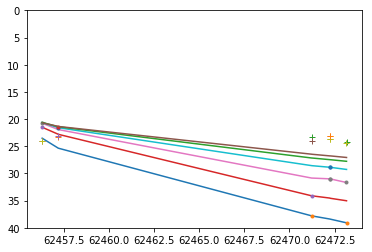

In [70]:
for flt in ['u', 'g', 'r', 'i', 'z', 'y']:
    plt.plot(lc['t_obs'], lc[flt], '-')
    
    df_r = df[ df['filter']==flt ]
    plt.plot(df_r.t, df_r.mag, '.')
    plt.plot(df_r.t, df_r.maglim, '+')


    plt.ylim([40,0])

In [65]:
# Let's see how we do.
for key in bd:
    print(key, bd[key].summaryValues)


baseline_v1_5_10yrs_KNePopMetric_USER {}
KNePopMetric__blue_color_detect {'Mean': 0.01}
KNePopMetric__multi_color_detect {'Mean': 0.11}
KNePopMetric__multi_detect {'Mean': 0.12}
KNePopMetric__red_color_detect {'Mean': 0.01}
KNePopMetric__ztfrest_simple {'Mean': 0.01}
KNePopMetric__ztfrest_simple_red {'Mean': 0.01}


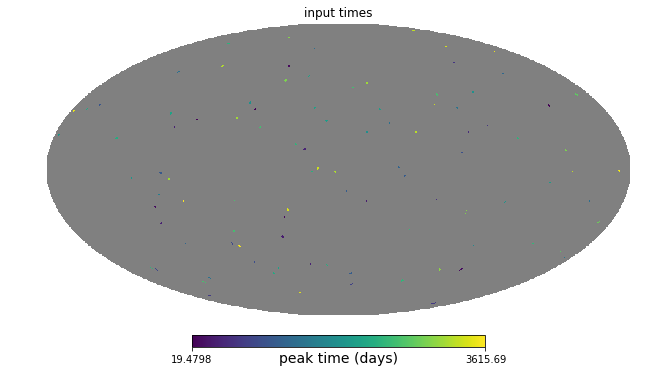

In [66]:
# Check that the positions and times look random
hp.mollview(_healbin(slicer.slicePoints['ra'], slicer.slicePoints['dec'], 
           slicer.slicePoints['peak_time'], 64, reduceFunc=np.mean), unit='peak time (days)',
           title='input times')


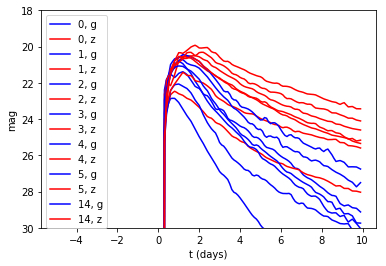

In [235]:
# let's plot up a few of the lightcurves
ivals=[0,1,2,3,4,5, 14]

for i in ivals:
    t = np.arange(-5, 10, 0.1)
    distmod = 5*np.log10(slicer.slicePoints['distance'][i]*1e6) - 5.0
    lc = metric.lightcurves.interp(t, 'g', lc_indx=slicer.slicePoints['file_indx'][i])
    plt.plot(t, lc+distmod, color='blue', label='%i, g' % i)
    lc = metric.lightcurves.interp(t, 'z', lc_indx=slicer.slicePoints['file_indx'][i])
    plt.plot(t, lc+distmod, color='red', label='%i, z' % i)
plt.ylim([30,18])
plt.xlabel('t (days)')
plt.ylabel('mag')
plt.legend()



In [37]:
# Let's see if there's a preference for which light curve was detected
indxes = np.unique(slicer.slicePoints['file_indx'])
for indx in indxes:
    in_indx = np.where(slicer.slicePoints['file_indx'] == indx)[0]
    n_total = in_indx.size
    print()
    # This simply requires two detections, regardless of band
    detected = bd['KNePopMetric__multi_detect'].metricValues[in_indx].sum()
    print('file indx %i and %f fraction recovered' % (indx, detected/n_total))



file indx 0 and 0.085714 fraction recovered

file indx 1 and 0.093750 fraction recovered

file indx 2 and 0.026316 fraction recovered

file indx 3 and 0.066667 fraction recovered

file indx 4 and 0.000000 fraction recovered

file indx 5 and 0.000000 fraction recovered

file indx 6 and 0.027778 fraction recovered

file indx 7 and 0.025000 fraction recovered

file indx 8 and 0.000000 fraction recovered

file indx 9 and 0.114286 fraction recovered

file indx 10 and 0.035714 fraction recovered

file indx 11 and 0.120000 fraction recovered

file indx 12 and 0.121212 fraction recovered

file indx 13 and 0.119048 fraction recovered

file indx 14 and 0.035714 fraction recovered

file indx 15 and 0.176471 fraction recovered

file indx 16 and 0.055556 fraction recovered

file indx 17 and 0.083333 fraction recovered

file indx 18 and 0.114286 fraction recovered

file indx 19 and 0.033333 fraction recovered

file indx 20 and 0.148148 fraction recovered

file indx 21 and 0.060606 fraction recovere


file indx 193 and 0.066667 fraction recovered

file indx 194 and 0.190476 fraction recovered

file indx 195 and 0.172414 fraction recovered

file indx 196 and 0.093750 fraction recovered

file indx 197 and 0.035714 fraction recovered

file indx 198 and 0.090909 fraction recovered

file indx 199 and 0.062500 fraction recovered

file indx 200 and 0.085714 fraction recovered

file indx 201 and 0.162162 fraction recovered

file indx 202 and 0.128205 fraction recovered

file indx 203 and 0.114286 fraction recovered

file indx 204 and 0.166667 fraction recovered

file indx 205 and 0.097561 fraction recovered

file indx 206 and 0.080000 fraction recovered

file indx 207 and 0.195122 fraction recovered

file indx 208 and 0.088235 fraction recovered

file indx 209 and 0.264706 fraction recovered

file indx 210 and 0.216216 fraction recovered

file indx 211 and 0.128205 fraction recovered

file indx 212 and 0.142857 fraction recovered

file indx 213 and 0.275862 fraction recovered

file indx 21

In [55]:
slicer.slicePoints

{'sid': array([   0,    1,    2, ..., 9997, 9998, 9999]),
 'ra': array([2.35330497, 5.97351416, 4.59925358, ..., 5.94834126, 2.49749071,
        1.3643334 ]),
 'dec': array([0.25548879, 0.34073063, 0.70455149, ..., 0.4034602 , 0.11360419,
        0.71480528]),
 'peak_time': array([2666.22383342,  674.65329593, 1266.58152414, ...,   72.03335514,
        1465.06867991,  940.76002162]),
 'file_indx': array([196, 141, 297, ...,  83, 133, 150]),
 'distance': array([221.8234327 , 166.47344791, 178.86440404, ..., 279.08792166,
        254.87842966, 289.04212735]),
 'ebv': array([0.04278291, 0.06107807, 0.0440214 , ..., 0.06617475, 0.0436486 ,
        0.50291288])}

In [54]:
slicer.slicePoints['file_indx']

array([196, 141, 297, ...,  83, 133, 150])

In [39]:
slicer.slicePoints['peak_time']

(10000,)

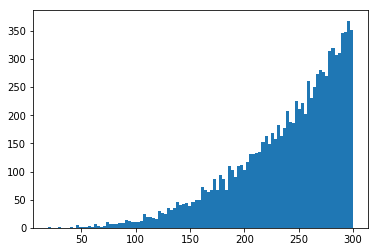

In [45]:
plt.hist(slicer.slicePoints['distance'], bins=100, );


In [47]:
len( file_list )

308